In [86]:
# Load Data
import pandas as pd
treated = pd.read_csv('treated.csv', index_col=0)
controls = pd.read_csv('control.csv', index_col=0)

In [87]:
len(treated.pidp.unique())

797

In [88]:
treated[treated.pidp==1088956767][['year', 'years_treated', 'year_reindex', 'year_treat_reindex', 'year_treated', 'aidhrs_recoded_3', 'employed', 'wage_h_deflated']]

,year,years_treated,year_reindex,year_treat_reindex,year_treated,aidhrs_recoded_3,employed,wage_h_deflated
8941,2010.0,3,1,6,2015.0,NaN,employed,14.367002
22844,2011.0,3,2,6,2015.0,NaN,employed,14.301820
34193,2012.0,3,3,6,2015.0,NaN,employed,12.843777
44239,2013.0,3,4,6,2015.0,NaN,employed,13.615916
53461,2014.0,3,5,6,2015.0,NaN,employed,9.274975
61878,2015.0,3,6,6,2015.0,0-19,employed,12.413794
70695,2016.0,3,7,6,2015.0,NaN,employed,11.560047
78688,2017.0,3,8,6,2015.0,NaN,employed,11.603128
86017,2018.0,3,9,6,2015.0,NaN,employed,11.565415
92836,2019.0,3,10,6,2015.0,0-19,employed,10.929585


In [89]:
controls[controls.pidp==1088956767] # this is important, dont delete, this case is duplicated.

,pidp,hidp,sex,jbnssec_dv,jbnssec8_dv,jbstat,jbhrs,jbft_dv,ethn_dv,dvage,...,high,low,middle,unemployed_bool,year_reindex,year_treated,year_treat_reindex,initial_year,reindex,years_treated


In [90]:
controls = controls[~(controls.pidp==1020477375)]

In [91]:
def get_control_clean(c_data, t_data):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        treat_time = t_data[t_data.pidp == t_id].year_treated.unique()[0]
        treat = t_data[t_data.pidp == t_id].pivot_table(index='year', columns='pidp', values='log_wage_h_deflated')
        control = c_data.pivot_table(index='year', columns='pidp', values='log_wage_h_deflated')
        sub_sample = pd.concat([treat, control], axis=1, join="inner") # concat-join-inner ensure using index (year) as key
        out['data'] = sub_sample.dropna(axis=1) # only complete columns
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [92]:
def is_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))
idx = []
for pidp in treated.pidp:
    idx.append(is_consecutive(treated[treated.pidp == pidp].wave))

In [ ]:
samples = get_control_clean(controls, treated)

In [93]:
from typing import List
from operator import add
from toolz import reduce, partial
import numpy as np
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from multiprocessing import Pool
import matplotlib.pyplot as plt

def create_index(x):
    y = np.arange(len(x)) + 1
    return y - x

def create_relative_index(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]

def create_relative_MultiIndex(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]


# the expression to minimise, since \mu is 0, we are one looking for \omega/W
def argmin_w(W, Y_i, Y_0):
    return np.sqrt(np.sum((Y_0 - Y_i.dot(W))**2))


# a function wrapping the whole process
def get_w(Y_i, Y_0):
    w_start = [1/Y_i.shape[1]]*Y_i.shape[1]
    weights = minimize(partial(argmin_w, Y_i=Y_i, Y_0=Y_0),
                       np.array(w_start),
                       method='SLSQP',
                       constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), # constraint to sum to 1
                       bounds=[(0.0, 1.0)]*len(w_start),
                       )
    return weights.x

def sc(x, k_n=250):
    data = x['data'].copy()
    t_time = x['treat_time']
    data.sort_index(inplace=True)
    data.index = data.index - t_time # 
    df_T0 = data.loc[:-1, :] # this needs to be revised
    Y_0 = df_T0.iloc[:, 0].values
    kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(df_T0.T, k=k_n, return_distance=False)[0, 1:]
    Y_i = df_T0.iloc[:, idx].values
    weights = get_w(Y_i, Y_0)
    synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
    treated = data.iloc[:, 0]
    diff = treated - synth
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff
    }


def isc(data_objects: list) -> dict:
    synths = []
    treats = []
    diffs = []
    std_diffs = []
    with Pool() as p:
        out = p.map(sc, data_objects)
    for ele in out:
        synths.append(ele['synth'])
        treats.append(ele['treated'])
        diffs.append(ele['diff'])
    return {'synths': synths,
            'treats': treats,
            'diffs': diffs}


In [12]:
# use cluster instead of nearest nieghtbours

In [13]:
samples[1]['data']

pidp,68150967,68035367,68042167,68044207,68045567,68060527,68105407,68163887,68167967,68167971,...,817077807,817255287,817271607,817271611,817917611,818586727,818586731,818637051,818645207,818715927
year,,,,,,,,,,,,,,,,,,,,,
2009.0,2.291935,2.844954,3.045583,2.456794,2.864763,3.004760,2.869218,2.769828,2.158293,2.097914,...,3.241023,2.158646,1.953109,2.780031,2.340970,2.927962,2.694245,2.684053,2.380668,2.015551
2010.0,2.726645,2.893653,3.178720,2.342095,2.864094,3.087558,2.784532,2.840712,2.292798,2.365164,...,3.329521,2.157442,2.018173,2.851557,2.835201,2.900174,4.356117,2.691327,2.456027,2.053573
2011.0,2.480478,2.866907,3.227051,2.393050,2.819695,3.203025,1.835531,2.728238,2.140919,2.500606,...,3.095619,2.192127,1.820317,2.328936,3.036745,3.038848,2.671020,2.852301,2.522891,2.088082
2012.0,2.297432,2.933377,3.222280,2.367380,2.788675,2.953080,2.758010,2.566281,2.345219,2.151847,...,3.060060,2.171293,1.837754,2.675134,2.513281,2.948818,2.567662,2.700058,2.454442,1.929705
2013.0,2.345338,3.412757,3.161013,2.407235,2.536312,3.031389,2.899129,2.804377,2.248630,2.391731,...,3.030048,2.261104,1.945642,2.382992,2.767025,2.663938,2.668583,2.628837,2.672211,2.078776
2014.0,2.243760,3.475546,3.192013,2.364121,2.615345,3.093074,2.678640,2.167814,2.202169,2.410922,...,2.862970,2.304353,1.907192,2.349843,2.924087,3.000409,2.716905,2.839915,2.806830,1.959519
2015.0,2.269146,3.541030,3.193944,2.459942,2.915460,2.975717,2.590225,1.904822,2.234238,2.433223,...,2.949951,2.521421,1.913674,2.307838,3.051775,2.937465,2.681693,2.884170,2.825522,-0.473769
2016.0,2.011823,3.490823,2.993421,2.488983,2.925890,3.091876,2.838359,2.632050,2.373471,2.056801,...,3.154047,2.397351,1.978265,2.558766,3.129453,2.947174,2.684596,2.733997,2.669812,1.997833
2017.0,2.221145,3.504519,3.176193,2.548488,2.952556,3.071138,3.072139,2.667514,2.384655,2.332011,...,2.919540,2.349875,1.727635,2.488420,3.115692,2.905535,2.639756,2.764291,2.607321,1.891613


In [14]:
sc(samples[100])

{'synth': year
 -3.0    1.956111
 -2.0    2.019153
 -1.0    1.948821
  0.0    2.043465
  1.0    2.079922
  2.0    2.087268
  3.0    2.099999
  4.0    2.109138
  5.0    2.167551
  6.0    2.159631
  7.0    2.229593
 dtype: float64,
 'treated': year
 -3.0    1.956112
 -2.0    2.019155
 -1.0    1.948820
  0.0    2.133228
  1.0    2.120023
  2.0    2.099717
  3.0    2.088101
  4.0    1.865803
  5.0    2.543102
  6.0    2.525084
  7.0    1.858977
 Name: 207325282, dtype: float64,
 'diff': year
 -3.0    0.000001
 -2.0    0.000002
 -1.0   -0.000001
  0.0    0.089764
  1.0    0.040101
  2.0    0.012449
  3.0   -0.011899
  4.0   -0.243335
  5.0    0.375552
  6.0    0.365453
  7.0   -0.370616
 dtype: float64}

In [15]:
out = isc(samples)

<Axes: xlabel='year'>

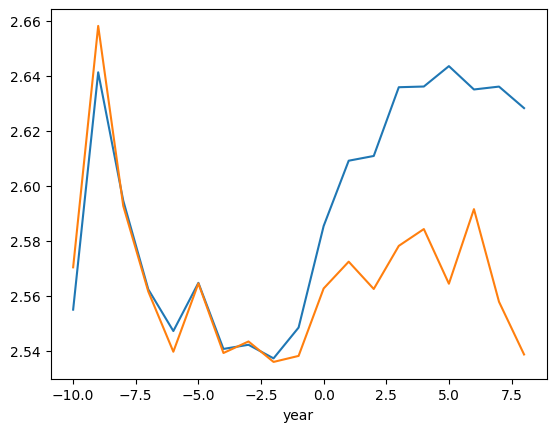

In [16]:
ss = pd.concat(out['synths'], axis=1).sort_index()
ts = pd.concat(out['treats'], axis=1).sort_index()
ss.mean(axis=1).plot()
ts.mean(axis=1).plot()

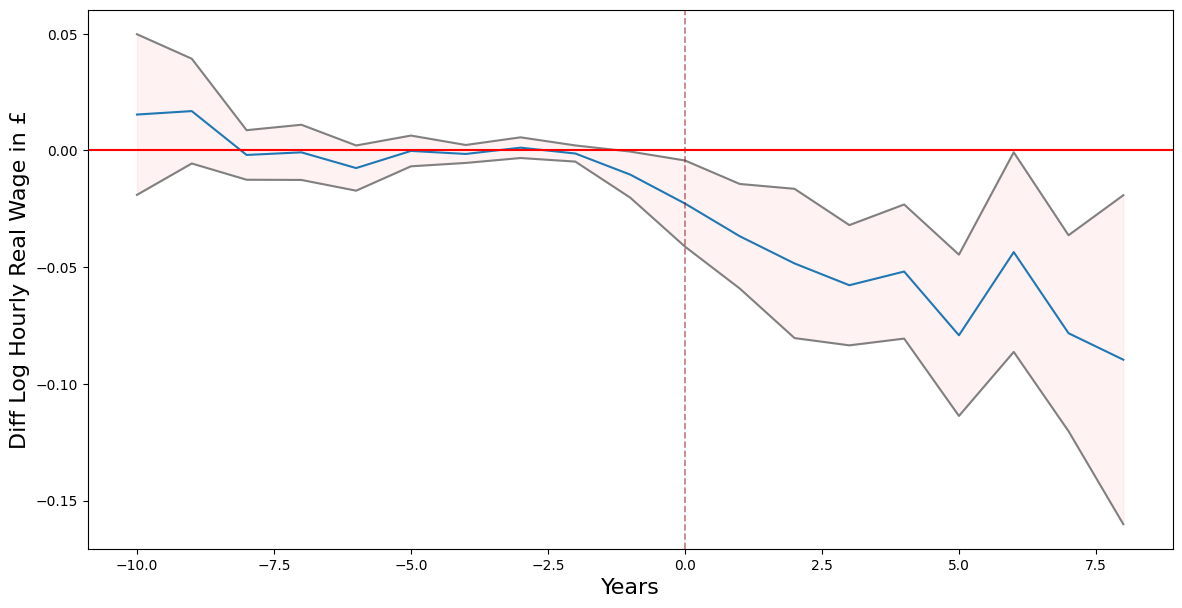

In [17]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

figure(figsize=(14, 7))
differences = pd.concat(out['diffs'], axis=1).sort_index()
differences.mean(axis=1).plot()
(differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt)))).plot(color='grey')
(differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt)))).plot(color='grey')
differences.count()
plt.axvline(x=0, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Diff Log Hourly Real Wage in £', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-')
plt.fill_between(x=differences.index,
                 y1=differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                 y2=differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.05)
plt.show()

# This next section includes covariates in the analysis

In [94]:
def get_control_clean(c_data, t_data, features, target_var):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        treat_time = t_data[t_data.pidp == t_id].year_treated.unique()[0]
        t_data = t_data.dropna(subset=['year']).copy()
        treat = t_data[t_data.pidp == t_id].pivot(index='pidp', columns='year')[features].T
        control = c_data.pivot(index='pidp', columns='year')[features].T
        sub_sample = pd.concat([treat, control], axis=1, join="inner") # concat-join-inner ensure using index (year) as key
        out['data'] = sub_sample.dropna(axis=1) # only complete columns
        out['treat_time'] = treat_time
        out['target_var'] = target_var
        samples.append(out)
    return samples

In [95]:
## I NEED TO MAKE SURE THE VARIABLES ARE ALWAYS NUMERIC.
new_samples = get_control_clean(controls, treated, ['log_wage_h_deflated', 'dvage', 'sex_recoded', 'mastat_recoded', 'asian', 'black', 'mixed', 'other', 'low', 'middle'], 'log_wage_h_deflated')

In [100]:
def sc(x, k_n=400):
    data = x['data'].copy()
    data.index.names = ['var', 'year']
    t_time = x['treat_time']
    target_var = x['target_var']
    data.index = data.index.map(lambda idx: (idx[0], idx[1] - t_time))
    data = data.sort_index(ascending=True).copy()
    df_T0 = data.loc[pd.IndexSlice[:, :-1], :]
    Y_0 = df_T0.iloc[:, 0].values
    kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(df_T0.T, k=k_n, return_distance=False)[0, 1:]
    Y_i = df_T0.iloc[:, idx].values
    weights = get_w(Y_i, Y_0)
    synth = data.iloc[:, idx].dot(weights).loc[target_var] # synthetic control is now based on the new subset of observations
    treated = data.iloc[:, 0].loc[target_var]
    diff = treated - synth
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff
    }

def isc(data_objects: list) -> dict:
    synths = []
    treats = []
    diffs = []
    std_diffs = []
    with Pool() as p:
        out = p.map(sc, data_objects)
    for ele in out:
        synths.append(ele['synth'])
        treats.append(ele['treated'])
        diffs.append(ele['diff'])
    return {'synths': synths,
            'treats': treats,
            'diffs': diffs}

In [101]:
out = isc(new_samples)

<Axes: xlabel='year'>

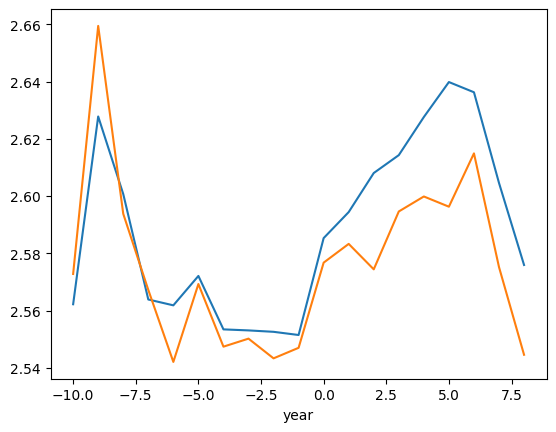

In [102]:
ss = pd.concat(out['synths'], axis=1).sort_index()
ts = pd.concat(out['treats'], axis=1).sort_index()
ss.mean(axis=1).plot()
ts.mean(axis=1).plot()

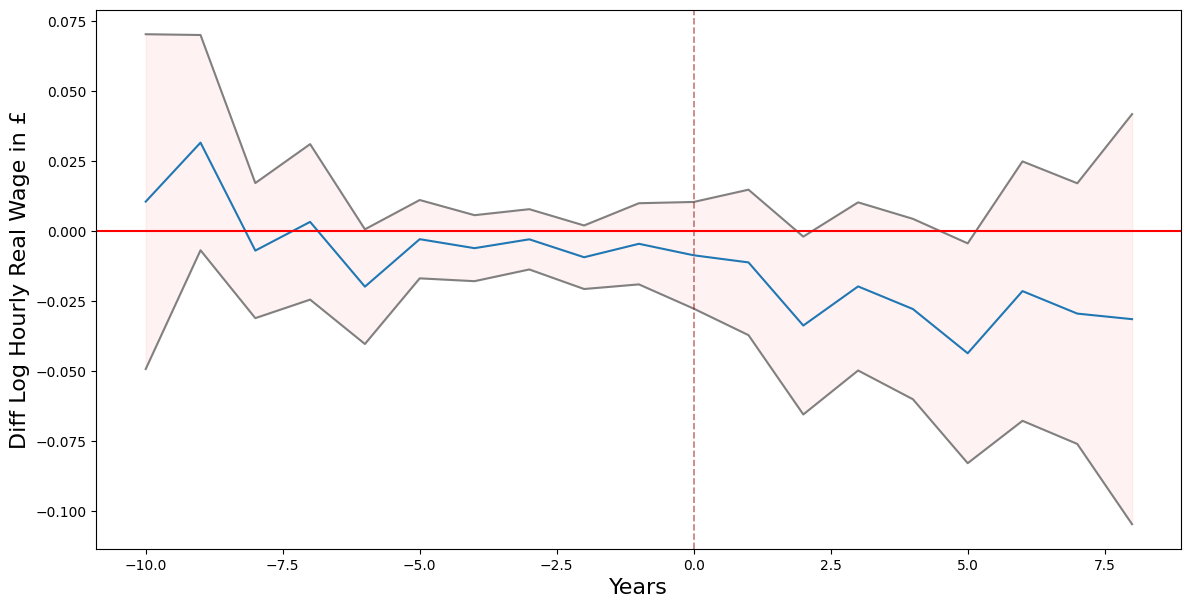

In [103]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

figure(figsize=(14, 7))
differences = pd.concat(out['diffs'], axis=1).sort_index()
differences.mean(axis=1).plot()
(differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt)))).plot(color='grey')
(differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt)))).plot(color='grey')
differences.count()
plt.axvline(x=0, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Diff Log Hourly Real Wage in £', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-')
plt.fill_between(x=differences.index,
                 y1=differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                 y2=differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.05)
plt.show()